In [1]:
import numpy as np 
import pandas as pd
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
import tensorflow as tf
import gensim
LabeledSentence = gensim.models.doc2vec.LabeledSentence
from tqdm import tqdm
import matplotlib.pyplot as plt

## Reading data

In [2]:
df = pd.read_csv('/home/luisernesto/Documents/MCSII/IntelligentSystem/work4/shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


## Preparing data

In [3]:
X = df.loc[:,'review'].values 
Y = df.loc[:,'sentiment'].values

In [4]:
stop = stopwords.words('english')
porter = PorterStemmer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    text = [w for w in text.split() if w not in stop]
    tokenized = [porter.stem(w) for w in text]
    return text

In [5]:
def tokenizer_start(data):
    for i in range (0,data.shape[0]):
        wordList = tokenizer(data[i])
        data[i] = wordList

### tokenizing reviews 

In [6]:
tokenizer_start(X)

In [7]:
X[0]

['1974',
 'teenager',
 'martha',
 'moxley',
 'maggie',
 'grace',
 'moves',
 'high',
 'class',
 'area',
 'belle',
 'greenwich',
 'connecticut',
 'mischief',
 'night',
 'eve',
 'halloween',
 'murdered',
 'backyard',
 'house',
 'murder',
 'remained',
 'unsolved',
 'twenty',
 'two',
 'years',
 'later',
 'writer',
 'mark',
 'fuhrman',
 'christopher',
 'meloni',
 'former',
 'la',
 'detective',
 'fallen',
 'disgrace',
 'perjury',
 'j',
 'simpson',
 'trial',
 'moved',
 'idaho',
 'decides',
 'investigate',
 'case',
 'partner',
 'stephen',
 'weeks',
 'andrew',
 'mitchell',
 'purpose',
 'writing',
 'book',
 'locals',
 'squirm',
 'welcome',
 'support',
 'retired',
 'detective',
 'steve',
 'carroll',
 'robert',
 'forster',
 'charge',
 'investigation',
 '70',
 'discover',
 'criminal',
 'net',
 'power',
 'money',
 'cover',
 'murder',
 'murder',
 'greenwich',
 'good',
 'tv',
 'movie',
 'true',
 'story',
 'murder',
 'fifteen',
 'years',
 'old',
 'girl',
 'committed',
 'wealthy',
 'teenager',
 'whose',


### Train and test Data 

In [8]:
xTrain = X[0:40000]
xTest = X[40000:50000]
yTrain = Y[0:40000].astype(np.float32)
yTest = Y[40000:50000].astype(np.float32)

### Embedding reviews 

We calculate the average number of words in all the reviews

In [9]:
numWords = []
for x in xTrain:
    count = len(x)
    numWords.append(count)
mean = np.mean(numWords)

In [10]:
W2V = Word2Vec(size=int(mean), min_count=10)
W2V.build_vocab(X)
W2V.train(X,total_examples=len(X),epochs=10)

(55670293, 59792260)

In [11]:
W2V.most_similar('good')

/home/luisernesto/yes/envs/python7.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('decent', 0.7566466927528381),
 ('great', 0.7416751384735107),
 ('bad', 0.6972256898880005),
 ('alright', 0.6910918354988098),
 ('ok', 0.6368938684463501),
 ('nice', 0.628466784954071),
 ('okay', 0.6031026840209961),
 ('fine', 0.5868966579437256),
 ('excellent', 0.5729685425758362),
 ('lousy', 0.5646825432777405)]

### Histogram of number words in the reviews 

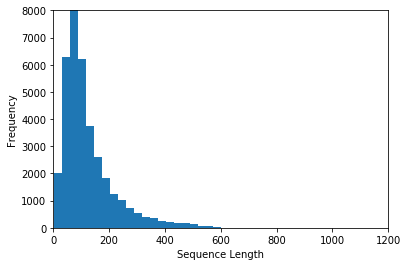

In [12]:
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

### Calculate the average of words in a review 

In [13]:
# Function to calculate the average of all word vectors in a review
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

# Function for calculating the average feature vector
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [14]:
print("Train data")
trainDataVecs = getAvgFeatureVecs(xTrain, W2V, int(mean))
print("Test data")
testDataVecs = getAvgFeatureVecs(xTest, W2V, int(mean))

Train data
Review 0 of 40000


/home/luisernesto/yes/envs/python7.1/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Review 1000 of 40000
Review 2000 of 40000
Review 3000 of 40000
Review 4000 of 40000
Review 5000 of 40000
Review 6000 of 40000
Review 7000 of 40000
Review 8000 of 40000
Review 9000 of 40000
Review 10000 of 40000
Review 11000 of 40000
Review 12000 of 40000
Review 13000 of 40000
Review 14000 of 40000
Review 15000 of 40000
Review 16000 of 40000
Review 17000 of 40000
Review 18000 of 40000
Review 19000 of 40000
Review 20000 of 40000
Review 21000 of 40000
Review 22000 of 40000
Review 23000 of 40000
Review 24000 of 40000
Review 25000 of 40000
Review 26000 of 40000
Review 27000 of 40000
Review 28000 of 40000
Review 29000 of 40000
Review 30000 of 40000
Review 31000 of 40000
Review 32000 of 40000
Review 33000 of 40000
Review 34000 of 40000
Review 35000 of 40000
Review 36000 of 40000
Review 37000 of 40000
Review 38000 of 40000
Review 39000 of 40000
Test data
Review 0 of 10000
Review 1000 of 10000
Review 2000 of 10000
Review 3000 of 10000
Review 4000 of 10000
Review 5000 of 10000
Review 6000 of 100

## LTSM and GRU with TensorFlow 

### Parameters 

In [28]:
learning_rate = np.power(10.0,-2.0)
training_steps = 20000
batch_size = 1000
display_step = 1000
num_input = 119
timesteps = 1
num_units = 119
num_classes = 1
num_layers = 9

### Implement bidirectional and multilayer LTSM RNN

In [29]:
tf.reset_default_graph()

X = tf.placeholder("float", [None, timesteps,num_input])
Y = tf.placeholder("float", [None,num_classes])

keep_prob = 1.0

weights = {
    'out': tf.Variable(tf.random_normal([num_units, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}
initializer = tf.random_uniform_initializer(-1, 1)
def RNN(x, weights, biases):
    outputs = x
    #track through the layers
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):
            
            #forward cells
            cell_fw = tf.contrib.rnn.LSTMCell(num_units,initializer=initializer)
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)
            #backward cells
            cell_bw = tf.contrib.rnn.LSTMCell(num_units,initializer=initializer)
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            (output_fw, output_bw), last_state = tf.nn.bidirectional_dynamic_rnn(cell_fw,cell_bw, outputs,dtype=tf.float32)
            state = last_state
            
    rnn_outputs_fw = tf.reshape(output_fw, [-1, num_units])
    rnn_outputs_bw = tf.reshape(output_bw, [-1, num_units])
    out_fw = tf.matmul(rnn_outputs_fw, weights['out']) + biases['out']
    out_bw = tf.matmul(rnn_outputs_bw, weights['out']) + biases['out']
    return np.add(out_fw,out_bw)

logits = RNN(X, weights, biases)

prediction = tf.nn.sigmoid(logits)

loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#calculate gradients 
gvs = optimizer.compute_gradients(loss_op)

#clipping gradients 
def ClipIfNotNone(grad):
    if grad is None:
        return grad
    return tf.clip_by_value(grad, -1, 1)
capped = [(ClipIfNotNone(grad),var) for grad,var in gvs]
train_op = optimizer.apply_gradients(capped)
optimizer.minimize(loss_op)

p5 = tf.constant(0.5)
delta = tf.abs((Y - prediction))
correct_prediction = tf.cast(tf.less(delta, p5), tf.int32)

#calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

## Start session 

In [30]:
accuracyTraining = []
lossTraining = []
steps = []
def startSession():
    with tf.Session() as sess:
        sess.run(init)
        count = 0
        startData = 0
        endData = batch_size
        
        test_len = 10000
        test_data = testDataVecs[:,:].reshape((-1, timesteps, num_input))
        test_label = yTest[:].reshape((10000,1))
        
        for step in range(1, training_steps+1):
            count+=1
            batch_x = trainDataVecs[startData:endData,:]
            batch_y = yTrain[startData:endData]
            batch_x = batch_x.reshape((batch_size, timesteps, num_input))
            batch_y = batch_y.reshape((batch_size,1))
            batch_y[:,:].astype(float)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            
            if step % display_step == 0 or step == 1:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                print("Step " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

                lossTraining.append(loss)
                steps.append(step)
                accu = sess.run(accuracy, feed_dict={X: test_data, Y: test_label})
                print("Testing Accuracy: ", accu)
                accuracyTraining.append(accu)
            if(endData<trainDataVecs.shape[0]):
                startData=count*batch_size
                endData = (count+1)*batch_size
            else:
                count=0
                startData = 0
                endData = batch_size
        print("Optimization Finished!")

### Results 

In [31]:
print("**********LTSM***********")
startSession()
ltsm_loss_training = lossTraining
ltsm_accuracy = accuracyTraining

**********LTSM***********
Step 1, Minibatch Loss= 1.0299, Training Accuracy= 0.574
Testing Accuracy:  0.5697
Step 1000, Minibatch Loss= 0.5347, Training Accuracy= 0.783
Testing Accuracy:  0.7725
Step 2000, Minibatch Loss= 0.4734, Training Accuracy= 0.808
Testing Accuracy:  0.8016
Step 3000, Minibatch Loss= 0.4421, Training Accuracy= 0.822
Testing Accuracy:  0.819
Step 4000, Minibatch Loss= 0.4219, Training Accuracy= 0.823
Testing Accuracy:  0.8277
Step 5000, Minibatch Loss= 0.4073, Training Accuracy= 0.832
Testing Accuracy:  0.8336
Step 6000, Minibatch Loss= 0.3961, Training Accuracy= 0.835
Testing Accuracy:  0.8369
Step 7000, Minibatch Loss= 0.3872, Training Accuracy= 0.842
Testing Accuracy:  0.8411
Step 8000, Minibatch Loss= 0.3799, Training Accuracy= 0.844
Testing Accuracy:  0.8439
Step 9000, Minibatch Loss= 0.3738, Training Accuracy= 0.850
Testing Accuracy:  0.8468
Step 10000, Minibatch Loss= 0.3686, Training Accuracy= 0.852
Testing Accuracy:  0.848
Step 11000, Minibatch Loss= 0.36

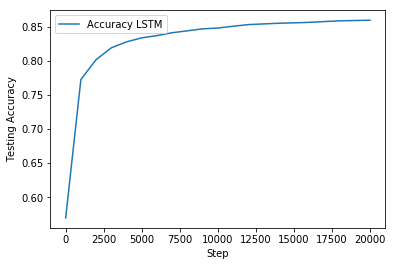

In [33]:
plt.xlabel('Step')
plt.ylabel('Testing Accuracy')
plt.plot(steps, ltsm_accuracy,label = 'Accuracy LSTM')
plt.legend()
plt.show()

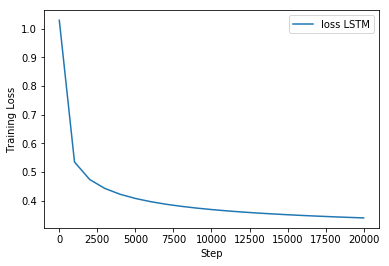

In [34]:
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.plot(steps, ltsm_loss_training,label = 'loss LSTM')
plt.legend()
plt.show()

In [38]:
print("Accuracy: ",ltsm_accuracy[int(training_steps/display_step)])

Accuracy:  0.8594
